# SpottedPy Tutorial


Download the sample data from: [zenodo_link](https://zenodo.org/records/12593757)


Tutorial to run SpottedPy on multiple Visium slides. Aim is to differentially compare gene signatures/ cell states within a slide. note: most informative plot is sp.plot_custom_scatter.

We will first load anndata object in with multiple slides labelled in batch column. 
All signatures and cell types have been labelled in .obs column. 

Note: To create an anndata object with all visium slides loaded together follow code below

In [ ]:
#merge anndata objects together with image data
#anndata_list= list of individual anndata objects 
"""
for i in range(len(anndata_list)):
    adata=anndata_list[i]
    adata.var_names_make_unique()
    anndata_list[i]=adata
anndata_list_concat=ad.concat(anndata_list, uns_merge="unique",index_unique="_")
unique_batch=anndata_list_concat.obs['batch'].unique()
count=0
for key, value in anndata_list_concat.uns['spatial'].items():
    #filter for the batch
    batch_subset = anndata_list_concat.obs['batch'] == unique_batch[count]
    anndata_list_concat.obs.loc[batch_subset, 'library_id'] = key
    print(key)
    count=count+1 
"""


In [ ]:
!pip install scanpy --upgrade
!pip install -U libpysal
!pip install esda

Set path to spottedpy

In [1]:
import scanpy as sc
import anndata as ad
import os
import numpy as np
import sys
import os 
sys.path.append("path/to/spottedpy")
import spottedpy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squidpy as sq
from tqdm import tqdm


Read in anndata ("anndata_tutorial_multiple_slides.h5ad") and ensure columns we are interested in calculating hotspots from are labelled in .obs column and fill the columns without the labels with nan to ensure create_hotspot does not use these values for hotspot creation. Ensure batch is labelled as a string.

In [2]:
#read in anndata visium object called "anndata_tutorial_multiple_slides.h5ad" found in zenodo
path="path/to/file"
#save the anndata object
anndata_breast=sc.read_h5ad(path)


# 1) Hotspot analysis

In [3]:
#It is the values in the .obs columns that we are interested in calculating hotspots from
TME_labels=[ 'angio_hallmarks', 'macro_siglec','nk_cells']
EMT_labels=['EPI','EMT']

Create hotspots for our EMT values and TME values. Hotspot and coldspots labels are found in .obs of anndata.  

If multiple slides are used, the slide labels should be labelled in .obs['batch'] and if plotting multiple slides, the Library ID in .uns data slot is the batch/slide label in .obs['batch'] column as a string.

Ensure scores are in the range of 0 to 1. 

relative_to_batch=True (default) ensures that the hotspot scores are calculated within each batch, useful for experiments with no change in condition (and batch correction does not need to be performed). However, if there is a change in condition, relative_to_batch=False could be used to understand more global changes, but batch correction should be performed first. 

```python  

In [4]:
for i in tqdm(TME_labels):
    anndata_breast=sp.create_hotspots(anndata_breast,column_name=i,neighbours_parameters=8,relative_to_batch=True)
#ensure we calculate hotspot from just tumour cells for emt_hallmarks
for i in tqdm(EMT_labels):
    anndata_breast=sp.create_hotspots(anndata_breast,filter_columns="tumour_cells",filter_value=1,column_name=i,neighbours_parameters=8,relative_to_batch=True)


100%|██████████| 2/2 [00:23<00:00, 11.63s/it]


In [6]:
#loop through TME_labels and add "_hot" to the end of each one so we calculate distances from them
TME_labels_hotspots=TME_labels.copy()
for i in range(0,len(TME_labels)):
    TME_labels_hotspots[i]=TME_labels[i]+'_hot'

Calculate distances from selected variables of interest. Number hotspots so we can accurately identify differential hotspots using GEE in the scatter plot. Note: comparison_variables and primary_variable variables must have "_hot" at the end (or _cold if comparing to a coldspot) so signify we are using this column. 

In [7]:
#primary variables are the hotspots we calculate distances from
#comparison variables are the hotspots we calculate distances to
primary_variables_values=['EPI_hot', 'EMT_hot']

distances=sp.calculateDistances(anndata_breast,primary_variables=primary_variables_values,comparison_variables=TME_labels_hotspots,empty_hotspot_default_to_max_distance=False,split_by_slide_in_batch=False,hotspot_number=True)



Plot mean distances from primary variables to comparison variables. Smaller bubble=closer distance.

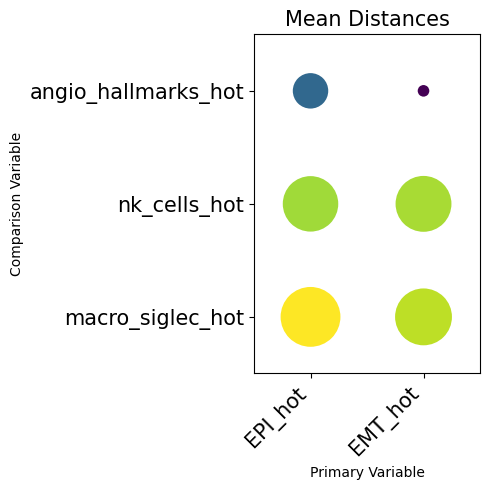

In [8]:
sp.plot_bubble_plot_mean_distances(distances,primary_vars=primary_variables_values,
                                        comparison_vars=TME_labels_hotspots,fig_size=(5,5),save_path="bubble_plot_mean_distances.pdf",)


C:\Users\ellwi\Documents\GitHub\Sp\spottedPy\sp_plotting.py:336: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df[filtered_df['comparison_variable'] == comparison_variable],
C:\Users\ellwi\Documents\GitHub\Sp\spottedPy\sp_plotting.py:339: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


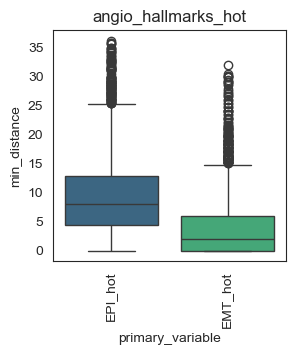

In [36]:
sp.plot_bar_plot_distance(distances,primary_variables=primary_variables_values,comparison_variables=['angio_hallmarks_hot'],fig_size=(3,3))


Plot hotspots on each slide.

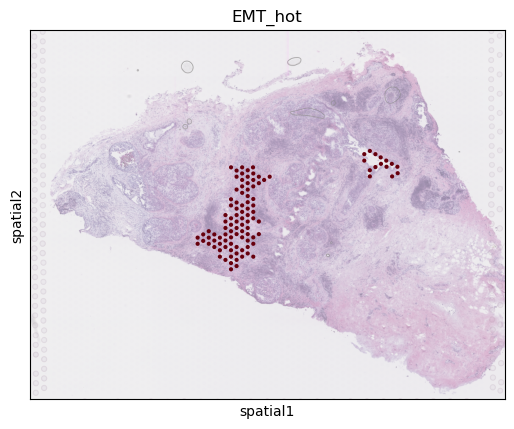

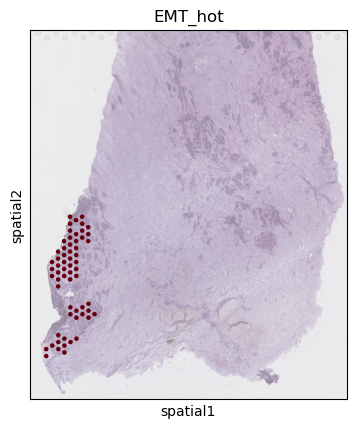

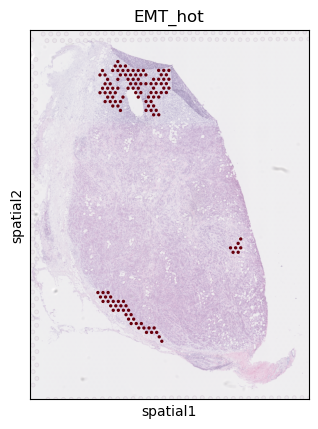

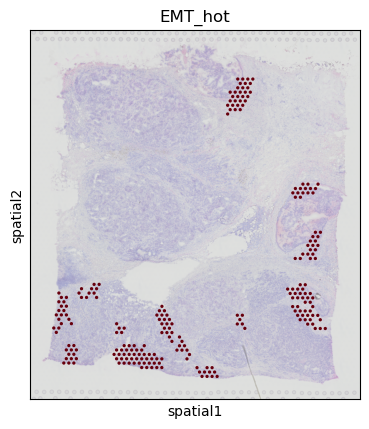

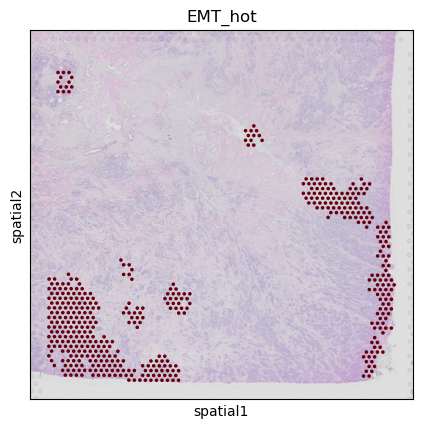

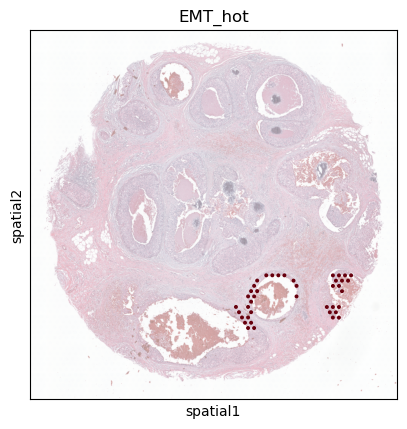

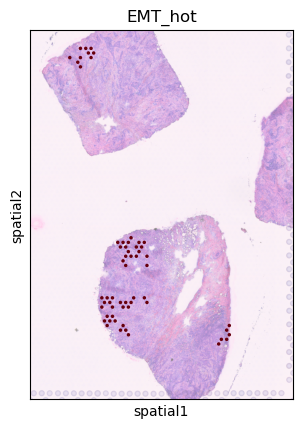

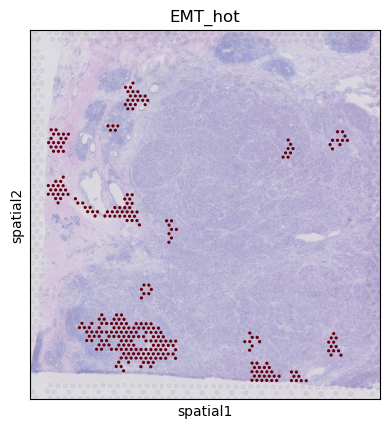

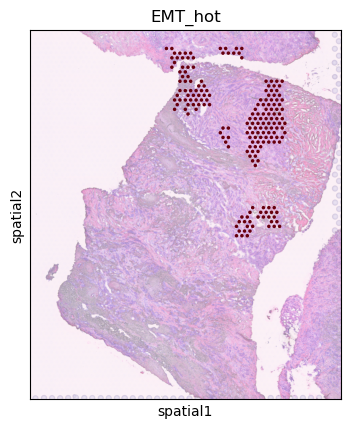

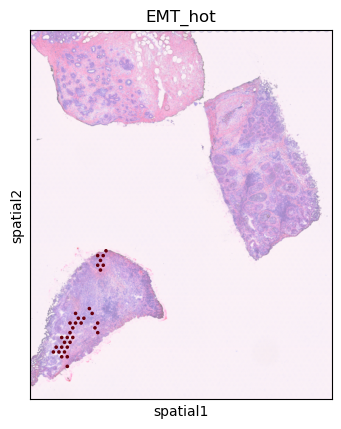

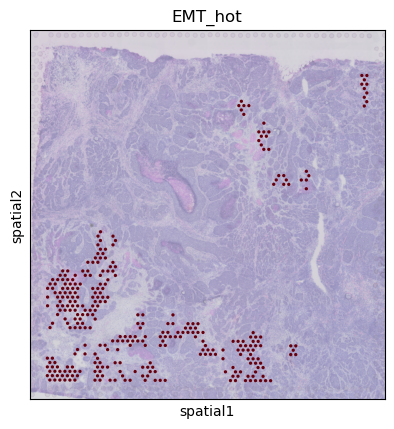

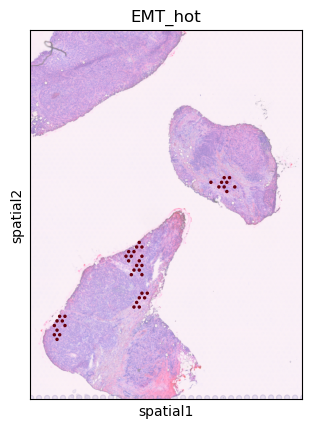

In [9]:
sp.plot_hotspots(anndata_breast,column_name="EMT_hot",save_path="EMT_hallmarks_hot.pdf")

This is the most informative plot. Choose two primary variables to compare in a comparison scatter plot and we statistcially assess whether there are spatial relationships between these cells/signatures. A reference is always required. This can be a "coldspot" of the signature (automatically created in create_hotspot function) indicating whether there is a low expression/proportion of the cell. 

First value in primary_vars will be variable we subtract distances from for comparison. Therefore negative value means first primary variable is closer to comparison variable, and a positive value means that the second primary variable is closer to the comparison variable.

 The distance metric used for comparison of hotspot distances can be set using compare_distance_metric. This set to equal to "min", "mean" or "median" compares the summary statistics for each hotspot across each slide using Generalised Estimating Equations which model enables us to estimate population-average effects involving repeated measurements across multiple spatial transcriptomic slides. The model estimates the coefficient for the transition from reference hotspots to comparison hotspot variables. 
 
 Setting compare_distance_metric to median_across_all_batches calculates the statistical significance of all hotspots together, therefore will be biased towards slides with more hotspots, but works better with fewer slides, <10.
```python

meta NOT subset; don't know how to subset; dropped


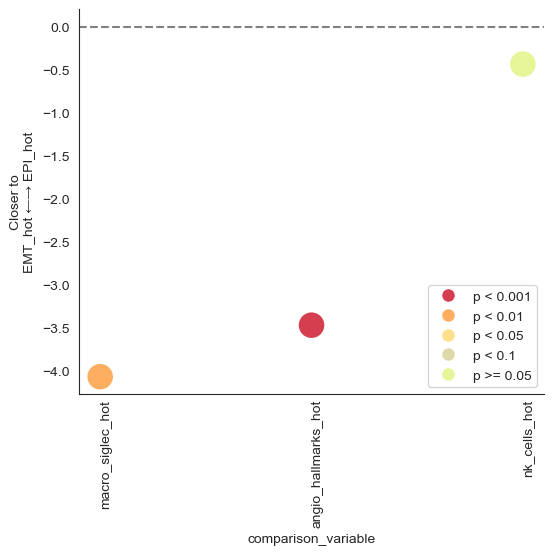

In [38]:

sp.plot_custom_scatter(data=distances, primary_vars=["EMT_hot","EPI_hot"], comparison_vars=TME_labels_hotspots, bubble_size=(400,400),fig_size=(6, 5),file_save=True,compare_distribution_metric="median")


Above, we can see that angiogenic hotspots are the closest hotspots to EMT hotspots, followed by hypoxia hotspots.

# Signature scoring

Measuring gene signature scores in hotspots and compare scores within the hotspots. 

c:\Users\ellwi\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(
c:\Users\ellwi\anaconda3\lib\site-packages\scanpy\tools\_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


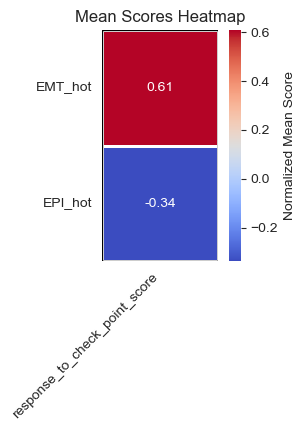

response_to_check_point_score
EMT_hot                       0.606826
EPI_hot                      -0.337249

In [39]:
response_to_check_point=['STAT1','CCR5','CXCL9','CXCL10','CXCL11','PRF1','GZMA','HLA-DRA']
gene_lists = [response_to_check_point]  # List of genes for each signature
gene_list_names = ['response_to_check_point']  # Names for each gene list
states_to_loop_through = ['EMT_hot', 'EPI_hot']  # States to be analyzed
anndata_breast, signatures = sp.score_genes_by_batch(anndata_breast, gene_lists, gene_list_names)
#return data so we can perform further analysis
sp.plot_gene_heatmap(anndata_breast, signatures, states_to_loop_through, plot_score=True, normalize_values=False,fig_size=(3,3),save_path="heatmap.pdf")


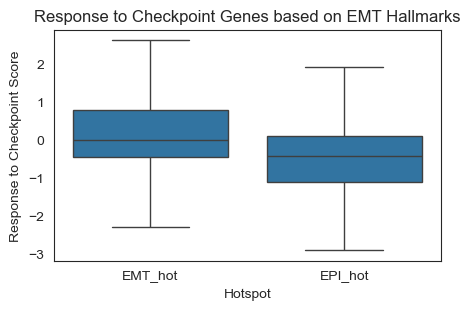

In [40]:
sp.plot_signature_boxplot(anndata_breast,hotspot_variable=['EMT_hot','EPI_hot'],signature='response_to_check_point_score',fig_size=(5,3))

# 

# Sensitivity analysis

Lets increase hypoxia, angiogenesis and emt hotspot size and see how relationship changes. Variable names (before _hot/_cold) need to be defined in .obs of anndata. 

        params['variable_comparison'] is the variable that is being compared to the other variables
        - params (dict): A dictionary with the following keys:
        * 'variable_comparison' (str): Name of the variable used for comparison.
        * 'variable_comparison_tumour' (bool): Indicates if data should be filtered for tumor cells for 'variable_comparison'.
        * 'sensitivity_parameter' (str): Specifies the sensitivity analysis parameter type ('pvalue' or 'neighbourhood').
        * 'variable_one' (str), 'variable_two' (str): Names of primary variables for distance calculation.
        * 'variable_one_two_is_tumour' (bool): Indicates if data should be filtered for tumor cells for 'variable_one' and 'variable_two'.
        * 'variable_three' (str): Reference variable for distance calculation. E.g .obs['tumour_cells']. Do not calculate hotspot for this. Remember: values in .obs in column without reference value should be nan.
        * 'values_to_test' (list): List of values to test for the sensitivity analysis.
        * 'file_name' (str): Name of the file to save the plot.
        * 'variable_comparison_constant' (bool): Indicates if the comparison variable should be varied.

In [ ]:
"""
#e.g. testing pvalue
params = {
    'variable_comparison': "macrophage_hot",
    'variable_one': "EMT_hallmarks_hot",
    'variable_two': "EMT_hallmarks_cold",
    #reference value, i.e. no hotspots calculated from it
    'variable_three': "tumour_cells",
    'values_to_test': [0.001,0.005,0.01,0.05,0.1,0.2],
    'variable_comparison_constant': True,
    'variable_comparison_tumour': False,
    'variable_one_two_is_tumour': True,
    'file_name': "sensitivity_plot_macrophage",
    'sensitivity_parameter': "pvalue"
}
"""

#testing neighbourhood
params = {
    'variable_comparison': "macro_siglec_hot",
    'variable_one': "EMT_hot",
    'variable_two': "EPI_hot",
    #reference value, i.e. no hotspots calculated from it
    'variable_three': "tumour_cells",
    'values_to_test': [1,2,5,10,20,50],
    'variable_comparison_constant': True,
    'variable_comparison_tumour': False,
    'variable_one_two_is_tumour': True,
    'save_path': "sensitivity_plot_macrophage",
    'sensitivity_parameter': "neighbourhood"
}
results = sp.sensitivity_calcs(anndata_breast, params)


Visualise all the distances calculated from the primary variable to the comparison variables. Note: unlike the scatter_plot function this does not summarise the min/median/mean distance from each hotspot and therefore may show different trends. scatter_plot is more statistically reliable to summarise group treands.

C:\Users\ellwi\Documents\GitHub\Sp\spottedPy\spottedpy.py:489: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)
meta NOT subset; don't know how to subset; dropped


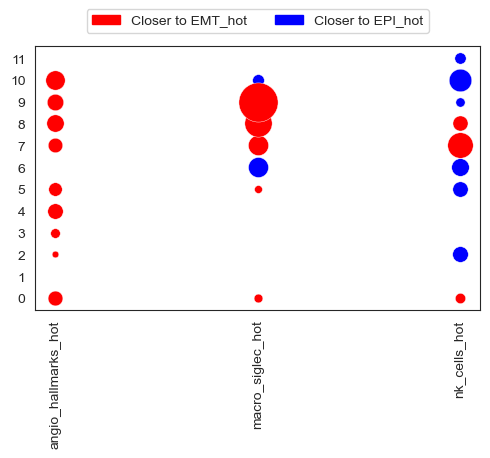

In [ ]:
#differences per batch (i.e. slide)
#returns distances for further analysis if needed
data=sp.plot_bubble_chart_by_batch(distances, primary_variable_value='EMT_hot',
                               comparison_variable_values=TME_labels_hotspots,
                               reference_variable="EPI_hot",
                               save_path="bubble_chart_by_batch.pdf",
                               pval_cutoff=0.05,
                               fig_size=(5,5))


# Plot individual hotspots

Plot the minimum distance distributions for EMT and EPI hotspots (primary variables in distances df) to angiogenic hotspots across all slides

<Figure size 300x500 with 0 Axes>

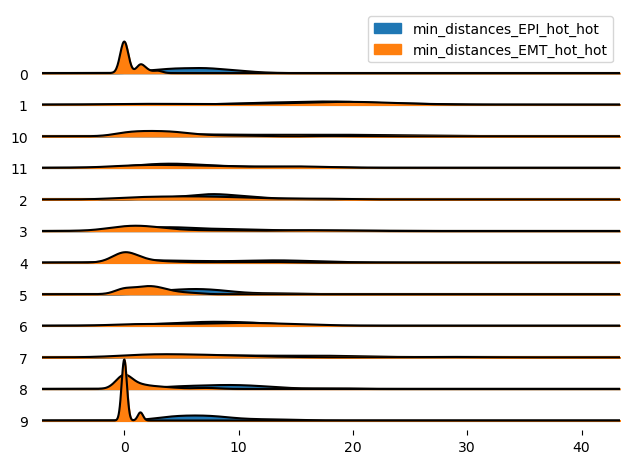

In [7]:
sp.plot_distance_distributions_across_batches(distances, "angio_hallmarks_hot",fig_size=(3,5))


Plot the minimum distance distributions for EMT and EPI hotspots (primary variables in distances df) to angiogenic hotspots in slide 0 on a hotspot level

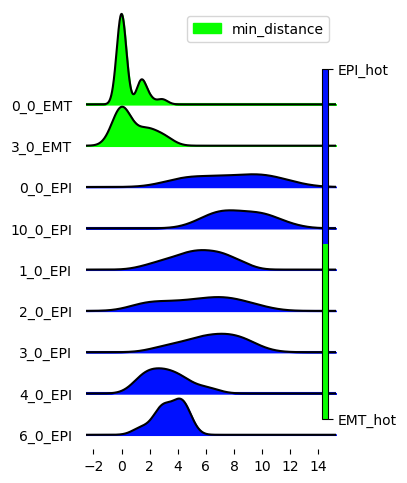

In [8]:
sp.access_individual_hotspots.plot_distance_distributions_across_hotspots(distances, "angio_hallmarks_hot","0")

Plot hotspot by number. Accessed in .obs column

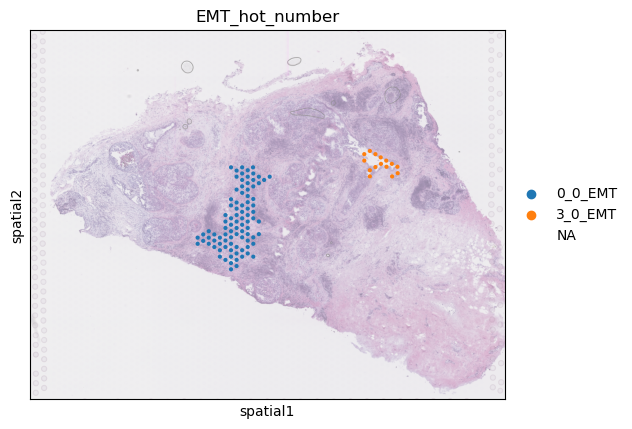

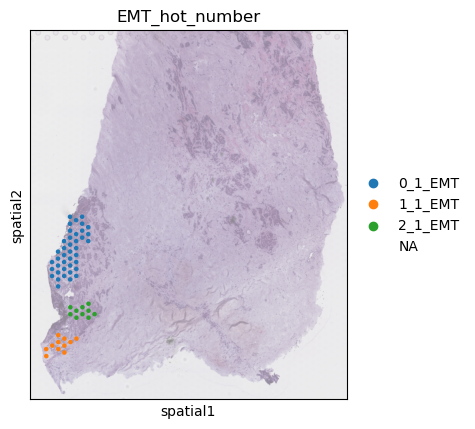

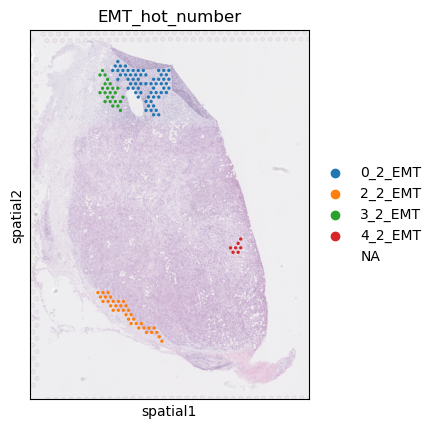

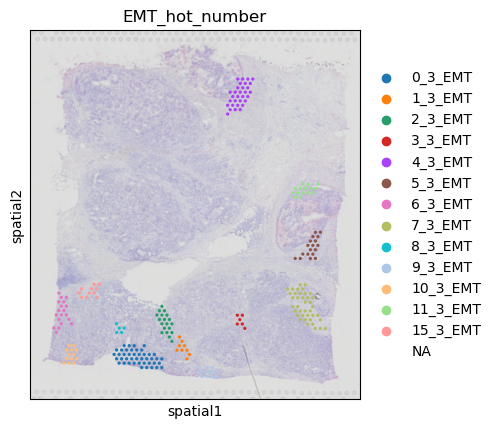

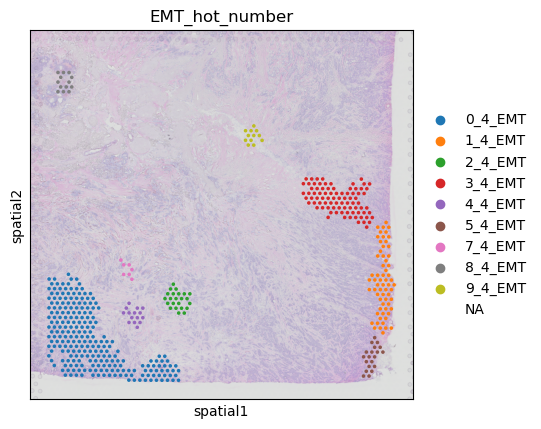

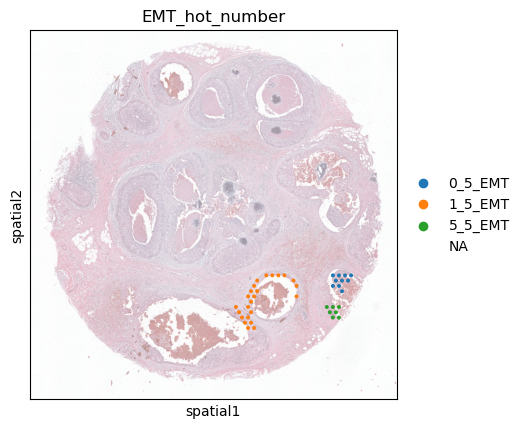

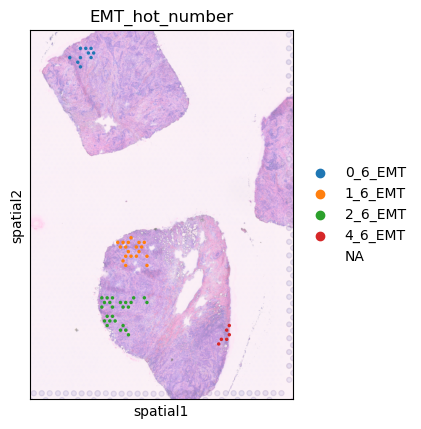

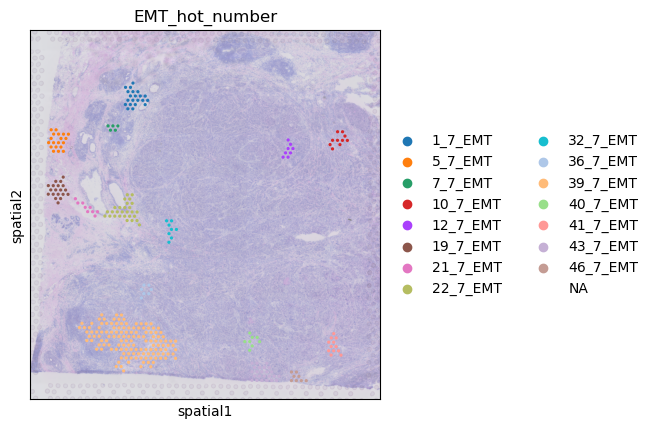

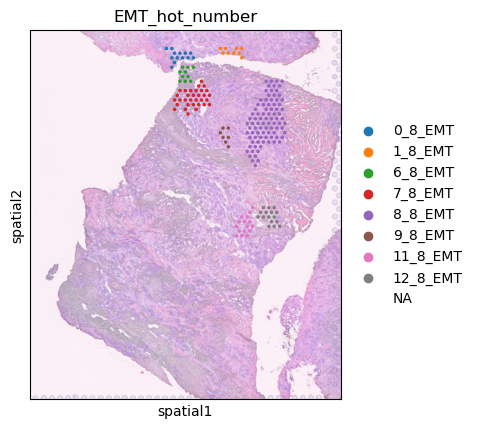

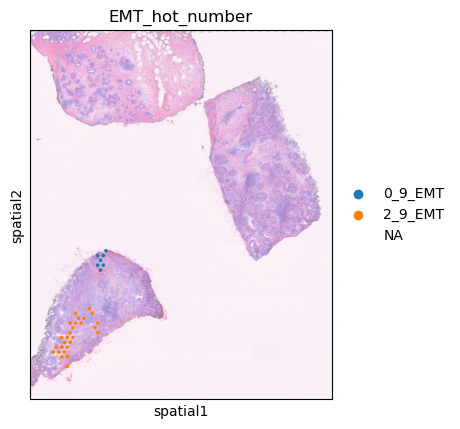

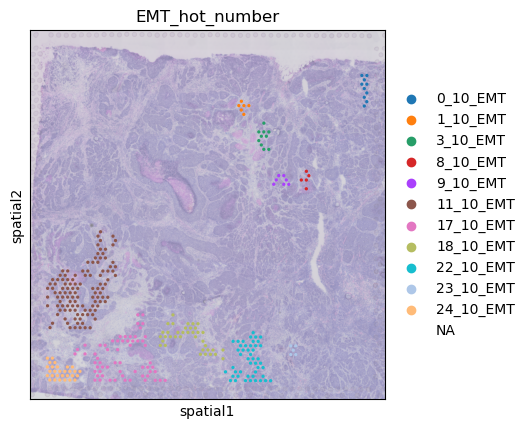

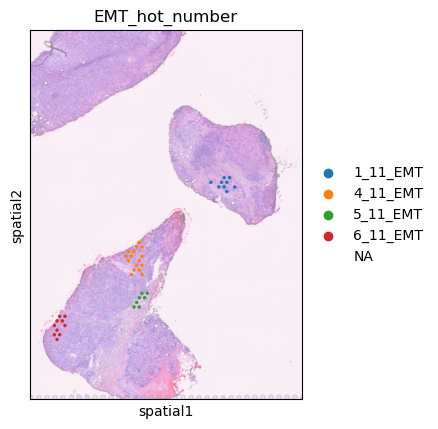

In [5]:
sp.plot_hotspots_by_number(anndata_breast, column_name="EMT_hot_number")

# 2) Neighbourhood correlation (correlate signatures within different neighbourhood settings)

Given the source_nodes (here filtered for tumour spots), we can calculate the correlation between signatures in the neighbourhood of each source node. Rings range specifies spatial unit. 

In [4]:
#results (dict): A dictionary where each key is the number of rings used for neighbor calculation, and each  value is a tuple containing the correlation matrix and the corresponding p-values matrix for those rings.
results = sp.calculate_neighbourhood_correlation(rings_range=[1,2,3], 
                                                           adata_vis=anndata_breast,
                                                           neighbour_variables=anndata_breast.obs[['EMT', 'angio_hallmarks', 'macro_siglec', 'nk_cells']],
                                                           source_nodes=anndata_breast[anndata_breast.obs['tumour_cells']==1].obs.index)


100%|██████████| 19442/19442 [00:41<00:00, 465.60it/s]


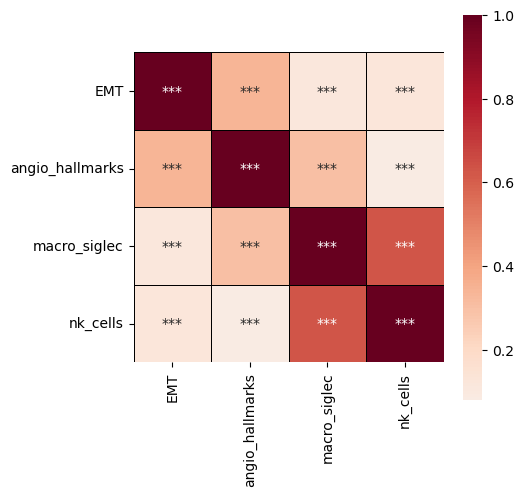

In [5]:
#select ring number to plot as a heatmap;
sp.correlation_heatmap_neighbourhood(results[1], variables=['EMT', 'angio_hallmarks', 'macro_siglec', 'nk_cells'],fig_size=(5,5),save_path="correlation_heatmap_neighbourhood.pdf")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
meta NOT subset; don't know how to subset; dropped


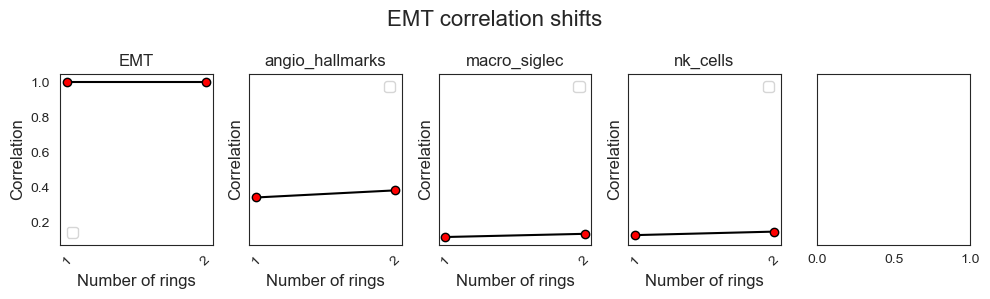

In [6]:
sp.plot_correlation_shifts(results,correlation_primary_variable='EMT',save_path="correlation_shifts.pdf")

meta NOT subset; don't know how to subset; dropped


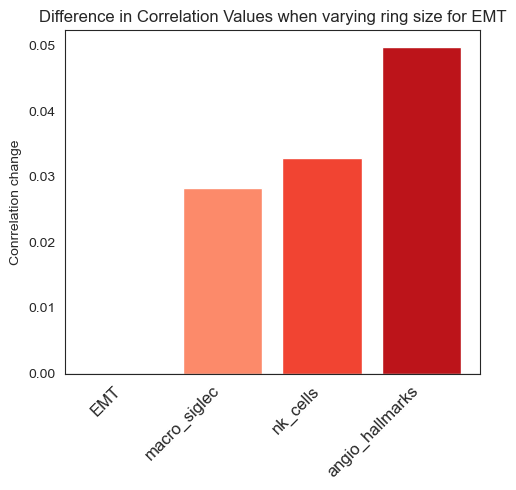

In [8]:
sp.plot_overall_change(results,correlation_primary_variable='EMT',save_path="overall_change.pdf",fig_size=(5,5))

# Correlate inner ring with outer ring (neighbourhood enrichment)

Takes longer than above. A different spatial unit approach, correlate inner ring with outer ring. Specify inner nodes for correlation e.g. tumour cells

In [ ]:
results_inner_outer=sp.calculate_inner_outer_neighbourhood_enrichment(rings_range=[1,2],adata_vis=anndata_breast,
                                                                           neighbour_variables=anndata_breast.obs[['EMT','angio_hallmarks', 'macro_siglec', 'nk_cells']],
                                                                           source_nodes=anndata_breast[anndata_breast.obs['tumour_cells']==1].obs.index)

In [ ]:
#using cell abundance from calculate_inner_outer_neighbourhood_enrichment, we calculate corr_df and pval that we can use to plot using functions previoulsy defined
#correlation_key_variable is the inner ring variable we want to correlate with the other variables in the outer rings
results_corr=sp.calculate_corr_pvalue_for_inner_outer_neighbourhood_enrichment(results_inner_outer,
                                                                               correlation_key_variable=['EMT'],
                                                                               rings_range=[1,2])


In [ ]:
sp.plot_correlation_shifts(results,correlation_primary_variable='EMT',save_path="correlation_shifts_inner_outer.pdf")